In [202]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import glob


In [203]:
label = glob.glob('./gtFine/train/*/*_gtFine_labelIds.png')

In [204]:
img=glob.glob('./leftImg8bit_trainvaltest/leftImg8bit/train/*/*.png')

In [205]:
img_val=glob.glob('./leftImg8bit_trainvaltest/leftImg8bit/val/*/*.png')

In [206]:
label_val = glob.glob('./gtFine/val/*/*_gtFine_labelIds.png')

In [207]:
len(img_val)

500

In [208]:
index=np.random.permutation(len(img)) ##亂序 確保 Img 與label是對應的

In [209]:
img=np.array(img)[index]
label=np.array(label)[index]

In [210]:
img[5]

'./leftImg8bit_trainvaltest/leftImg8bit/train\\stuttgart\\stuttgart_000078_000019_leftImg8bit.png'

In [211]:
label[5]

'./gtFine/train\\stuttgart\\stuttgart_000078_000019_gtFine_labelIds.png'

In [212]:
dataset_train=tf.data.Dataset.from_tensor_slices((img,label))

In [213]:
dataset_val=tf.data.Dataset.from_tensor_slices((img_val,label_val))

In [214]:
def read_png(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_png(img,channels=3)
    return img

In [215]:
def read_label_png(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_png(img,channels=1)
    return img

數據增強##

if tf.random.uniform()>0.5:
    tf.image.flip_left_right          ##1.隨機翻轉

In [216]:
img_1=read_png(img[0])

In [217]:
label_1=read_label_png(label[0])

In [218]:
concat=tf.concat([img_1,label_1],axis=-1)

In [219]:
def crop_img(img,mask):
    concat_img=tf.concat([img,mask],axis=-1)
    concat_img=tf.image.resize(concat_img,(280,280),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img=tf.image.random_crop(concat_img,[256,256,4])
    return crop_img[:,:,:3],crop_img[:,:,3:],           #####2.隨機裁減

####模型

In [220]:
image1,label1=crop_img(img_1,label_1)

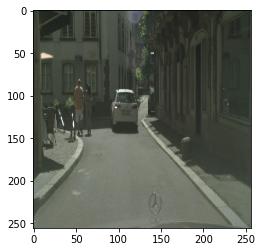

In [221]:
plt.imshow(image1)

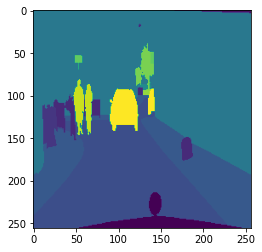

In [222]:
plt.imshow(label1)

In [223]:
label1

<tf.Tensor: shape=(256, 256, 1), dtype=uint8, numpy=
array([[[11],
        [11],
        [11],
        ...,
        [ 2],
        [ 2],
        [ 2]],

       [[11],
        [11],
        [11],
        ...,
        [ 2],
        [ 2],
        [ 2]],

       [[11],
        [11],
        [11],
        ...,
        [ 2],
        [ 2],
        [ 2]],

       ...,

       [[ 7],
        [ 7],
        [ 7],
        ...,
        [ 8],
        [ 8],
        [ 8]],

       [[ 7],
        [ 7],
        [ 7],
        ...,
        [ 8],
        [ 8],
        [ 8]],

       [[ 7],
        [ 7],
        [ 7],
        ...,
        [ 8],
        [ 8],
        [ 8]]], dtype=uint8)>

In [224]:
def normal(img,mask):
    img=tf.cast(img,tf.float32)/127.5-1
    mask=tf.cast(mask,tf.int32)
    return img,mask

In [225]:
def load_image_train(img_path,mask_path):
    img=read_png(img_path)           #讀取img
    label=read_label_png(mask_path)  #讀取lable
    img,label=crop_img(img,label)    #隨機裁減img與lable (同時)
    if tf.random.uniform(())>0.5:                
        img=tf.image.flip_left_right(img)          ###隨機翻轉
        label=tf.image.flip_left_right(label)
    img,mask=normal(img,label)
    return img,mask

In [226]:
def load_image_val(img_path,mask_path): ######驗證資料/測試資料 不需要做數據強化
    img=read_png(img_path)           #讀取img
    label=read_label_png(mask_path)  #讀取lable
    #img,label=crop_img(img,label)    #隨機裁減img與lable (同時)
    #if tf.random.uniform(())>0.5:                
   #     img=tf.image.flip_left_right(img)          ###隨機翻轉
   #     label=tf.image.flip_left_right(label)
    img=tf.image.resize(img,(256,256))
    label=tf.image.resize(label,(256,256))
    img,mask=normal(img,label)
    return img,mask

In [227]:
BATCH_SIZE=32
BUFFER_SIZE=300
step_per_epoch=len(label)//BATCH_SIZE
val_step=len(img_val)//BATCH_SIZE

In [228]:
auto = tf.data.experimental.AUTOTUNE

In [229]:
dataset_train=dataset_train.map(load_image_train,num_parallel_calls=auto)
dataset_val=dataset_val.map(load_image_val,num_parallel_calls=auto)

In [230]:
dataset_train

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>

In [231]:
dataset_val

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>

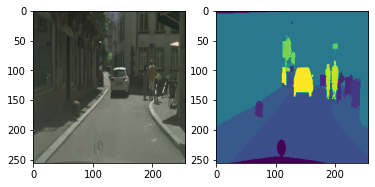

In [232]:
for i,m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(m)

In [233]:
dataset_train=dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [234]:
dataset_val=dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

###模型

In [235]:
class Downsample(tf.keras.layers.Layer):
    def __init__(self,units):
        super(Downsample,self).__init__()
        self.conv1=tf.keras.layers.Conv2D(units,kernel_size=3,padding='same')
        self.conv2=tf.keras.layers.Conv2D(units,kernel_size=3,padding='same')
        self.pool=tf.keras.layers.MaxPooling2D()
    def call(self,x,is_pool=True):
        if is_pool:
            x = self.pool(x)
        x=self.conv1(x)
        x=tf.nn.relu(x)
        x=self.conv2(x)
        x=tf.nn.relu(x)
        return x

In [236]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self,units):
        super(Upsample,self).__init__()
        self.conv1=tf.keras.layers.Conv2D(units,kernel_size=3,padding='same')
        self.conv2=tf.keras.layers.Conv2D(units,kernel_size=3,padding='same')
        self.deconv=tf.keras.layers.Conv2DTranspose(units//5,kernel_size=2,strides=2,padding='same')
    def call(self,x):
        x=self.conv1(x)
        x=tf.nn.relu(x)
        x=self.conv2(x)
        x=tf.nn.relu(x)
        x=self.decov(x)
        x=tf.nn.relu
        return x

In [257]:
class Uet_model(tf.keras.Model):
    def __init__(self):
        super(Uet_model,self).__init__()
        self.down1=Downsample(64)
        self.down2=Downsample(128)
        self.down3=Downsample(256)
        self.down4=Downsample(512)
        self.down5=Downsample(1024)
        
        self.up=tf.keras.layers.Conv2DTranspose(512,kernel_size=2,strides=2,padding='same')
        self.up1=Upsample(512)
        self.up2=Upsample(256)
        self.up3=Upsample(128)
        
        self.cove_last=Downsample(64)
        
        self.last=tf.keras.layers.Conv2D(34,kernel_size=1,padding='same')
        
    def call(self,x):
        x=self.down1(x,is_pool=False)
        x2=self.down2(x)
        x3=self.down3(x)
        x4=self.down4(x)
        x5=self.down5(x)
            
        x5=self.up(x5)
        x5=tf.concat([x4,x5],axis=-1)
            
        x5=self.up1(x5)
        x5=tf.concat([x3,x5],axis=-1)
            
        x5=self.up2(x5)
        x5=tf.concat([x2,x5],axis=-1)
            
        x5=self.up3(x5)
        x5=tf.concat([x,x5],axis=-1)
            
        x5=slef.cove_last(x,is_pool=False)
            
        x5=self.last(x5)
            
        return x5

In [258]:
model=Uet_model()

In [239]:
opt = tf.keras.optimizers.Adam(0.0001)


In [240]:
loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #######模型輸出最後一層未激化的話 from_logits=True

In [248]:
class MeanIOU(tf.keras.metrics.MeanIoU):
    def __call__(self,y_ture,y_pred):
        y_pred=tf.argmax(y_pred)
        
        return super().__call__(y_ture,y_pred)

In [242]:
train_loss=tf.keras.metrics.Mean(name='train_loss')
train_acc=tf.keras.metrics.SparseCategoricalAccuracy(name='train_loss') #為甚麼使用SparseCategoricalAccuracy/ 因為輸出為34張量,與原數據是不同的
train_iou=MeanIOU(34,name='train_iou')

In [243]:
test_loss=tf.keras.metrics.Mean(name='test_loss')
test_acc=tf.keras.metrics.SparseCategoricalAccuracy(name='test_loss') #為甚麼使用SparseCategoricalAccuracy/ 因為輸出為34張量,與原數據是不同的
test_iou=MeanIOU(34,name='test_iou')

In [244]:
def train_step(image,labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels,predictions)
    gradients=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels,predictions)
    train_ios(labels,predictions)

In [250]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIOU(34, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIOU(34, name='test_iou')

In [251]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

In [252]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

In [259]:


EPOCHS = 10

for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:.3f}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))

TypeError: 'NoneType' object is not callable